# 1. Extract Multi-instance images from COCO

### 1.1 3x3 grid image with annotations

In [10]:
from PIL import Image
import os
from pycocotools.coco import COCO
import json


# Loads an image, resizes it to 256x256, scales its bounding boxes, and saves the resized image. Returns the updated annotations.
def save_image(img_info, anns,img_dir, output_dir):
    img_path = os.path.normpath(os.path.join(img_dir, img_info['file_name'])) # get the image path, normalizing the path to handle mixed separators

    # print("img_path = ",img_path)
    os.makedirs(output_dir, exist_ok=True)
    # print("output_dir = ",save_dir)


    # Check if the file exists before opening
    if not os.path.exists(img_path):
        print(f"Skipping {img_path} - File not found.")
        return  

    # load the image
    img = Image.open(img_path)

    # cal the scaling factor for width and height, for cal BB later 
    width, height = img.size
    scale_w = 256 / width
    scale_h = 256 / height

    # resize the image to 256*256
    img = img.resize((256, 256))
    img_info['width'] = 256
    img_info['height'] = 256

    save_path = os.path.join(output_dir, img_info['file_name'])
    img.save(save_path)


    # resize the BB according to the scaling factor
    new_anns = []
    for ann in anns:
        # get the BB
        x, y, w, h = ann['bbox']

        # scale the BB
        x *= scale_w
        y *= scale_h
        w *= scale_w
        h *= scale_h
        # update the BB
        ann['bbox'] = [x, y, w, h]
        ann['area'] = w*h

        new_anns.append(ann)

    return new_anns



def update_annotation_file(new_images, updated_anns, original_ann_file):
    # Load the original annotation file to retrieve the categories information
    with open(original_ann_file, 'r') as f:
        original_data = json.load(f)
    
    # Update the images and annotations fields
    original_data['images'] = new_images
    original_data['annotations'] = updated_anns
    
    # Write the updated data back to the original file
    with open(original_ann_file, 'w') as f:
        json.dump(original_data, f)



def extract_images(cat_names, img_dir, output_dir , original_ann_file):

    ## Requirements:
    # 1. Contains at least one foreground object. A foreground object must be from one of the 
    # three categories: [ ’pizza’, ’cat’, ’bus’].

    # 2. Additionally, the area of any foreground object must be larger than 200×200 = 40000 pixels. 
    # There can be multiple foreground objects in an image since we are dealing with multi-instance 
    # object localization for this homework. If there is none, that image should be discarded.

    # 3. When saving your images to disk, resize them to 256×256. Note that you would also need to 
    # scale the bounding box parameters accordingly after resizing

    cat_ids = coco.getCatIds(catNms=cat_names)

    # get all image IDs containing the above categories
    img_ids = coco.getImgIds(catIds=cat_ids)

    min_area = 40000  # 200x200


    # List to store valid images
    valid_images = []
    target_category = ["pizza", "cat", "bus"]
    updated_anns_total = []

    # loop through the images
    for img_id in img_ids:
        img_info = coco.loadImgs(img_id)[0] # get image info to save the data later
        
        # !!! !!! !!! !!! !!! !!!this is for val only!!! !!! !!! !!! !!! !!!
        if "COCO_train2014_" in img_info["file_name"]:
            print(f"Skipping Training Image: {img_info['file_name']}")
            continue  # Skip this image 

        # These are annotation IDs for objects detected in a specific image. (we are not using this)
        ann_ids = coco.getAnnIds(imgIds=img_id, iscrowd=False)

        # anns includes bounding box, category ID, and segmentation, area, imageID!!!!!!!!!!!!!!!!
        anns = coco.loadAnns(ann_ids)

        # Filter annotations: keep only those whose category is in foreground_categories 
        # and whose area is larger than min_area.
        valid_anns = []

        for ann in anns:
            # return object category name, like obj_category: umbrella, obj_category: carrot...
            obj_category = coco.loadCats(ann['category_id'])[0]['name']
            
            # if this object category is in target_category and area is larger than min_area
            if obj_category in target_category and ann['area'] > min_area:
                valid_anns.append(ann)
        
        
        # print(f"Found {len(valid_images)} images with valid annotations.") ## 3957 for training, 2062 for validation.

        # If at least one valid annotation exists, save the image and update the annotations
        if valid_anns:
            new_anns = save_image(img_info, valid_anns, img_dir, output_dir) 

            if new_anns:
                valid_images.append(img_info)
                updated_anns_total.extend(new_anns)

    return valid_images, updated_anns_total




# Set COCO dataset paths
# data_dir = os.getcwd()

#  mac users
# ann_file = os.path.join(data_dir, "annotations/instances_train2014.json") 
# image_dir = os.path.join(data_dir, "train2014/train2014")  

# windows users


# ann_file_train = "./../data/annotations/instances_train2014.json"
# image_dir_train = "./../HW6/train2014/train2014" 
# output_dir_train = "./../data/Multi-instance_images_from_COCO(HW7)/train"
# os.makedirs(output_dir_train, exist_ok=True)


ann_file_val = "./../data/annotations/instances_val2014.json"
image_dir_val = "./../data/val2014"
output_dir_val = "./../data/Multi-instance_images_from_COCO(HW7)/val"
os.makedirs(output_dir_val, exist_ok=True)


all_new_images = []
all_updated_anns = []


# # Load COCO dataset
# coco = COCO(ann_file_train)

# valid_images, updated_anns_total= extract_images(["pizza"], img_dir = image_dir_train, output_dir = output_dir_train, original_ann_file =ann_file_train)
# all_new_images.extend(valid_images)
# all_updated_anns.extend(updated_anns_total)

# valid_images, updated_anns_total= extract_images(["cat"], img_dir = image_dir_train, output_dir = output_dir_train, original_ann_file =ann_file_train)
# all_new_images.extend(valid_images)
# all_updated_anns.extend(updated_anns_total)

# valid_images, updated_anns_total= extract_images(["bus"], img_dir = image_dir_train, output_dir = output_dir_train, original_ann_file =ann_file_train)
# all_new_images.extend(valid_images)
# all_updated_anns.extend(updated_anns_total)

# update_annotation_file(all_new_images, all_updated_anns, ann_file_train)


all_new_images = []
all_updated_anns = []

# Load COCO dataset
print(f"Loading COCO annotation file: {ann_file_val}")  # Debugging output

coco = COCO(ann_file_val)

valid_images, updated_anns_total= extract_images(["pizza"], img_dir = image_dir_val, output_dir = output_dir_val, original_ann_file =ann_file_val)
all_new_images.extend(valid_images)
all_updated_anns.extend(updated_anns_total)

valid_images, updated_anns_total= extract_images(["cat"], img_dir = image_dir_val, output_dir = output_dir_val, original_ann_file =ann_file_val)
all_new_images.extend(valid_images)
all_updated_anns.extend(updated_anns_total)

valid_images, updated_anns_total= extract_images(["bus"], img_dir = image_dir_val, output_dir = output_dir_val, original_ann_file =ann_file_val)
all_new_images.extend(valid_images)
all_updated_anns.extend(updated_anns_total)

update_annotation_file(all_new_images, all_updated_anns, ann_file_val)


Loading COCO annotation file: ./../data/annotations/instances_val2014.json
loading annotations into memory...
Done (t=0.08s)
creating index...
index created!
Skipping Training Image: COCO_train2014_000000106497.jpg
Skipping Training Image: COCO_train2014_000000548874.jpg
Skipping Training Image: COCO_train2014_000000344080.jpg
Skipping Training Image: COCO_train2014_000000090151.jpg
Skipping Training Image: COCO_train2014_000000516139.jpg
Skipping Training Image: COCO_train2014_000000442416.jpg
Skipping Training Image: COCO_train2014_000000483382.jpg
Skipping Training Image: COCO_train2014_000000335935.jpg
Skipping Training Image: COCO_train2014_000000032843.jpg
Skipping Training Image: COCO_train2014_000000213070.jpg
Skipping Training Image: COCO_train2014_000000041041.jpg
Skipping Training Image: COCO_train2014_000000581715.jpg
Skipping Training Image: COCO_train2014_000000172121.jpg
Skipping Training Image: COCO_train2014_000000155741.jpg
Skipping Training Image: COCO_train2014_0000

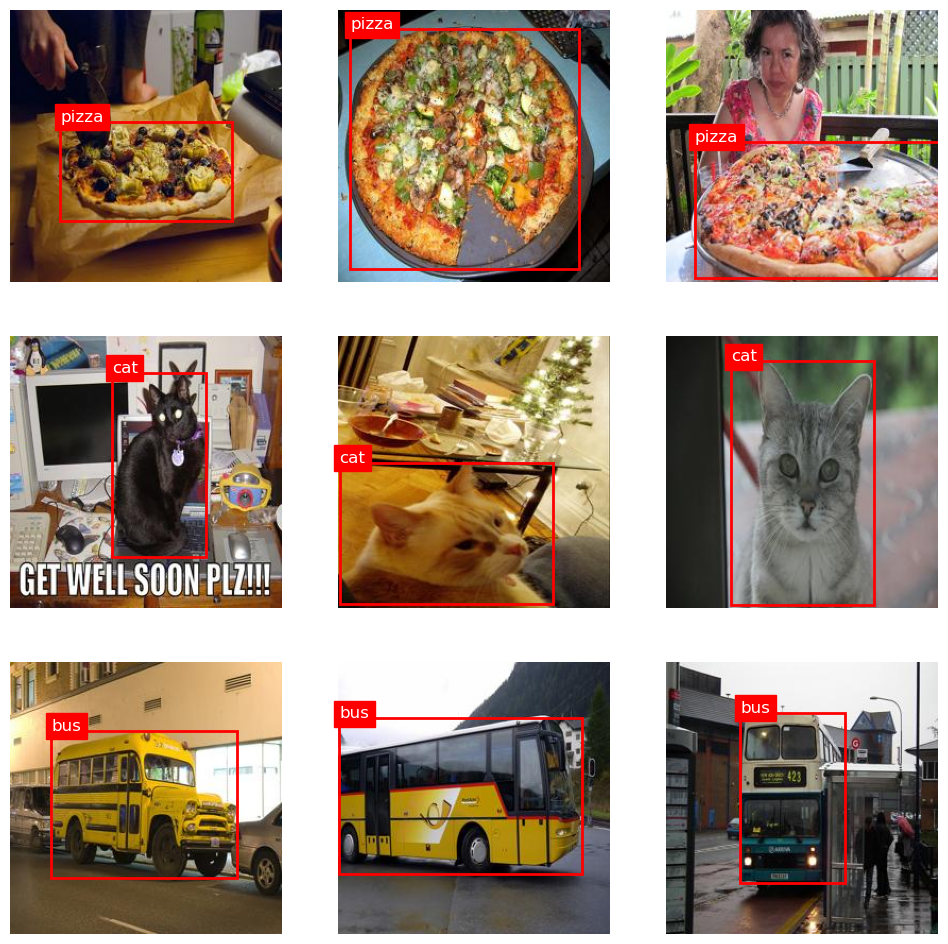

In [14]:
import os
import json
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

def visualize_images(annotation_file, image_dir):
    # Load the updated annotation file 
    with open(annotation_file, 'r') as f:
        data = json.load(f)
    
    # Build mappings for images and catID2name
    images = {img["id"]: img for img in data["images"]}
    cat_id_to_name = {cat["id"]: cat["name"] for cat in data["categories"]}
    # print("images\n",images) ## {466949: {'license': 1, 'file_name': 'COCO_train2014_000000466949.jpg', 'coco_url': 'http://images.cocodataset.org/train2014/COCO_train2014_000000466949.jpg', 'height': ....
    # print("cat_id_to_name\n",cat_id_to_name) ## {1: 'person', 2: 'bicycle', 3: 'car'...

    
    target_categories = ["pizza", "cat", "bus"]
    # get their ID
    cat_to_img_ids = {cat: set() for cat in target_categories} # set for avoiding duplicate ## cat_to_img_ids = {'pizza': set(), 'cat': set(), 'bus': set()}
    for ann in data["annotations"]:
        cat_name = cat_id_to_name[ann["category_id"]]
        if cat_name in target_categories:
            cat_to_img_ids[cat_name].add(ann["image_id"])
    
    # Select 3 images per category 
    selected_ids = []
    for cat in target_categories:
        count = 0
        # print("\n\n",cat)
        for img_id in cat_to_img_ids[cat]:
            # print("check",img_id)
            if img_id not in selected_ids:
                selected_ids.append(img_id)
                # print("add",img_id)
                count += 1
            if count == 3:
                break

    # print(selected_ids)
 

    # plot the 3x3 graph
    fig, axs = plt.subplots(3, 3, figsize=(12, 12))
    axs = axs.flatten()
    for i, img_id in enumerate(selected_ids):
        img_info = images[img_id]
        img_path = os.path.join(image_dir, img_info["file_name"])
        
        # Open the image using PIL
        img = Image.open(img_path)

        axs[i].imshow(img)
        axs[i].axis("off")
        
        # For each annotation in the image, add a rectangle patch and label it with the category name
        for ann in data["annotations"]:
            if ann["image_id"] == img_id:
                bbox = ann["bbox"] # Format: [x, y, width, height]

                # Create a rectangle patch for the bounding box
                rect = Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], fill=False, edgecolor='red', linewidth=2)
                axs[i].add_patch(rect)

                # Add the category name label at the top-left corner of the bounding box
                cat_name = cat_id_to_name[ann["category_id"]]
                axs[i].text(bbox[0], bbox[1], cat_name,fontsize=12, color='white', backgroundcolor='red')
        
    plt.show()



updated_annotation_file = "./../data/annotations/instances_train2014.json"
resized_image_dir = "./../data/Multi-instance_images_from_COCO(HW7)/train"

visualize_images(updated_annotation_file, resized_image_dir)


# 2. Dataloader

### 2.1 Code block showing all parameters for yolo vector are generated 
### & 
### 3.1 Code block showing how yolo tensor is built

In [12]:
import os
import json
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import numpy as np
import torchvision.transforms as transforms
import torchvision


class MyDataset(Dataset):
    def __init__(self, ann_file, image_dir, transform):
        # Load the annotation JSON file
        with open(ann_file, 'r') as f:
            self.annotation = json.load(f)
        
        self.image_dir = image_dir
        self.transform = transform


        # generate grid locations
        """
        Grid coordinates(top left corner):
        [[  0.   0.]
        [ 32.   0.]
        [ 64.   0.]
        [ 96.   0.]
        [128.   0.]
        [160.   0.]
        [192.   0.]
        [224.   0.]
        [  0.  32.]
        [ 32.  32.]
        [ 64.  32.]
        [ 96.  32.]
        ...
        [128. 224.]
        [160. 224.]
        [192. 224.]
        [224. 224.]]
        """
        self.num_cells = 6
        self.cell_size = 128 / self.num_cells
        GridCell = []  
        # for j in range(self.num_cells):      # Outer loop over rows (y-coordinate)
        #     for i in range(self.num_cells):  # Inner loop over columns (x-coordinate)
        #         x_coord = i * self.cell_size
        #         y_coord = j * self.cell_size
        #         GridCell.append([x_coord, y_coord])
                
        # self.GridCell = np.array(GridCell)  # Convert the list to a NumPy array
        x, y = np.meshgrid(np.arange(self.num_cells), np.arange(self.num_cells))
        self.GridCell = np.vstack((x.ravel(), y.ravel())).T * 128 / self.num_cells

        # create anchor box
        # provides for 5 anchor boxes for each cell with the following aspect ratios: 1/5, 1/3, 1/1, 3/1, 5/1. 
        # stor as [x1, y1, x2, y2], where: x1, y1 is the bottom-left corner and x2, y2 is the top-right corner.
        anchor_box = list()
        anchor_box.append([0,0,self.cell_size, self.cell_size]) # 1:1 
        anchor_box.append([0,-1 * self.cell_size, self.cell_size, 2 * self.cell_size]) # 1:3         # make sure it is centered
        anchor_box.append([0,-2 * self.cell_size, self.cell_size,3 * self.cell_size]) # 1:5
        anchor_box.append([-1 * self.cell_size, 0,2 * self.cell_size,self.cell_size]) # 3:1
        anchor_box.append([-2 * self.cell_size,0, 3 * self.cell_size,self.cell_size]) # 5:1

        self.anchor_box = torch.tensor(anchor_box)
        
        # Build an index mapping image id to its annotations
        self.img_id_to_anns = {}
        for ann in self.annotation['annotations']:
            img_id = ann['image_id']
            if img_id not in self.img_id_to_anns:
                self.img_id_to_anns[img_id] = []
            self.img_id_to_anns[img_id].append(ann)
        
        # List of image info dictionaries
        self.images = self.annotation['images']



        # --- MAPPING ORIGINAL CATEGORY IDs TO 0, 1, 2 ---
        # COCO IDs for your classes: pizza (59), cat (17), bus (6)
        self.catid_to_idx = {59: 0, 17: 1, 6: 2,'background': 3}  # Add this mapping

    
    def __len__(self):
        return len(self.images)
    
    
    def __getitem__(self, idx):
        # Get image info and path
        img_info = self.images[idx]
        img_path = os.path.join(self.image_dir, img_info['file_name'])
        
        # Load the image and ensure it is in RGB format
        try:
            image = Image.open(img_path).convert('RGB')
        except Exception as e:
            print(f"Error: Could not open image {img_path}. Exception: {e}")

        # GridCellIdx = list()
        # anchorBoxIdx = list()
        # bboxData = list()
        labels =  list()

        # initialize ground truth(number of anchorbox per grid cell, number of grid cells, yolo vector size of 5 + number of class)
        GroundTruth = torch.zeros(5, self.num_cells * self.num_cells, 9) 
        
        # Retrieve all annotations corresponding to this image
        img_id = img_info['id']
        anns = self.img_id_to_anns.get(img_id, [])
        
        image = self.transform(image)

        # loop through the,
        for ann in anns:
            bbox = ann['bbox']        # COCO format: [x, y, width, height]
            bbox = np.array([bbox[0], bbox[1], bbox[0]+bbox[2], bbox[1]+bbox[3]]) 

            center_of_bbox = np.array([(bbox[0]+bbox[2])/2, (bbox[1]+bbox[3])/2])

            # calculate the distance to all the grid cell, and get the closest one(the offset is the center of the grid cell)
            x_y_diff = (center_of_bbox- 128/self.num_cells/2) - self.GridCell
            # find the closest grid cell
            grid_cell_idx = np.argmin(np.sum(x_y_diff**2, axis=1)) # sum the square of x and y difference, and find the smallest one
            offset = torch.tensor(np.array([self.GridCell[grid_cell_idx], self.GridCell[grid_cell_idx]]).reshape(1,4), dtype=self.anchor_box.dtype)
            shifted_anchor_boxes = self.anchor_box + offset
            # calculate the IOU
            # get GT box first
            GT_box = torch.tensor(bbox.flatten()).unsqueeze(0)
            # get the best anchor box with max IOU
            anchor_box = np.argmax(torchvision.ops.box_iou(GT_box, torch.tensor(shifted_anchor_boxes)).numpy())

            # calculate the x, y, w, h 
            x = (center_of_bbox[0] - self.GridCell[grid_cell_idx][0]) / self.cell_size
            y = (center_of_bbox[1] - self.GridCell[grid_cell_idx][1]) / self.cell_size
            BestBox = shifted_anchor_boxes[anchor_box]  # Get the best anchor box coordinates
            w = np.log((bbox[2] - bbox[0]) / (BestBox[2] - BestBox[0]))
            h = np.log((bbox[3] - bbox[1]) / (BestBox[3] - BestBox[1]))

            # update the ground truth
            label = np.zeros(4)
            mapped_idx = self.catid_to_idx[ann['category_id']]
            label[mapped_idx] = 1
            GroundTruth[anchor_box, grid_cell_idx] = torch.tensor([1, x, y, w, h, label[0], label[1], label[2], 0])

            # GridCellIdx.append(grid_cell_idx)
            # anchorBoxIdx.append(anchor_box)
            # bboxData.append([1, x, y, w, h])
            labels.append(ann['category_id'])


        return image, GroundTruth, len(labels)
            


transform_train = transforms.Compose([
    # transforms.RandomHorizontalFlip(),      # don;t want to update the bbox
    # transforms.RandomRotation(5),         
    transforms.Resize((128, 128)), 

    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]) 
])

transform_val = transforms.Compose([
    transforms.Resize((128, 128)), 

    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]) 
])
ann_file_train = "./../data/annotations/instances_train2014.json"
output_dir_train = "./../data/Multi-instance_images_from_COCO(HW7)/train"
ann_file_val = "./../data/annotations/instances_val2014.json"
output_dir_val = "./../data/Multi-instance_images_from_COCO(HW7)/val"

train_dataset = MyDataset(ann_file=ann_file_train, image_dir=output_dir_train, transform=transform_train)
val_dataset = MyDataset(ann_file=ann_file_val, image_dir=output_dir_val, transform=transform_val)

# Create a DataLoader to iterate through the dataset
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)


sample = train_dataset[0]
image, GroundTruth, lenlable = sample
print("Image shape:", image.shape)
print("GroundTruth shaple:", GroundTruth.shape)
# print("GroundTruth",GroundTruth)
print("len(labels)", lenlable)



Image shape: torch.Size([3, 128, 128])
GroundTruth shaple: torch.Size([5, 36, 9])
len(labels) 1


/tmp/ipykernel_2621648/827607155.py:132: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  anchor_box = np.argmax(torchvision.ops.box_iou(GT_box, torch.tensor(shifted_anchor_boxes)).numpy())
/tmp/ipykernel_2621648/827607155.py:138: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  w = np.log((bbox[2] - bbox[0]) / (BestBox[2] - BestBox[0]))
/tmp/ipykernel_2621648/827607155.py:139: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  h = np.log((bbox[3] - bbox[1]) / (BestBox[3] - BestBox[1]))


### 2.2 explanationg showing all parameters for yolo vector are generated

- **yolo_vector**

##### Anchor Boxes per Grid Cell
- **Anchor Boxes:** 5 per grid cell with different aspect ratios (1:1, 1:3, 1:5, 3:1, 5:1).
- **Representation:** Each anchor box is defined as [x1, y1, x2, y2]:
  - x1, y1: Bottom-left coordinates relative to the grid cell.
  - X2, y2: Top-right coordinates relative to the grid cell.

##### YOLO Vector Structure
- **Total Elements:** 1 + 4 + 4 = 9 elements per YOLO vector.
- **Details:**
  1. **Element 0:** Objectness score (confidence of object presence).
  2. **Elements 1–4:** Bounding box parameters:
     - x, y: Offsets of object center relative to top-left of grid cell (normalized).
     - w, h: Logarithmic differences between actual box dimensions and anchor box dimensions.
  3. **Elements 5–8:** Class prediction scores:
     - Includes an additional background class, making it 4 elements for 3 classes.

##### 1D YOLO Vector Format
- Shape: (9,) for a single bounding box prediction.
- **Components:** [cx, cy, w, h, pc, p1, p2, ... pn]
  - cx, cy: Center coordinates of the bounding box (normalized).
  - w, h: Width and height of the bounding box (normalized).
  - pc: Confidence score (probability of object presence).
  - p1, p2, ... pn: Class probabilities (softmax output for each class).

##### example Code block

```
# Shape: [5 anchor boxes, num_cells*num_cells grid cells, 9-element YOLO vector]
GroundTruth = torch.zeros(5, self.num_cells * self.num_cells, 9)

# Populate the YOLO vector for a detected object
GroundTruth[anchor_box, grid_cell_idx] = torch.tensor([1, x, y, w, h, label[0], label[1], label[2], 0])
```

### 3.2 explanation of building how yolo tensor is built


##### 1. **Grid Division**
- **Image Size:** Resized to 128×128 pixels.
- **Grid:** Divided into a 6×6 grid, resulting in **36 grid cells**.
- **Cell Coordinates:** Computed using a meshgrid and scaled by cell size = 128 / 6.

##### 2. **YOLO Vectors per Grid Cell**
- **Anchor Boxes:** Each cell has **5 anchor boxes**.
- **YOLO Vector:** Each anchor box is represented by a **9-element vector**.
- **Tensor Shape:** The YOLO TE are stored in a tensor with shape [5, 36, 9]:
  - 5: Number of anchor boxes per cell.
  - 36: Total grid cells (6×6).
  - 9: Length of each YOLO vector.

##### 3. **Flattened Representation**
- **Total Elements:** 5 × 36 × 9 = 1620.
- **Network Output:** The final fully connected layer outputs **1620 values**, reshaped to [5, 36, 9].

##### 4. **GroundTruth Tensor**
- **Shape:** torch.Size([5, 36, 9]).
- **Interpretation:** Each grid cell contains 5 potential predictions, each represented by a 9-element vector.

##### example Code block
```
# In __getitem__ method
GroundTruth = torch.zeros(5, self.num_cells * self.num_cells, 9)
# 5 anchor boxes, 36 grid cells (6×6), 9-element YOLO vector
# Output shape: [5, 36, 9]
```

# 3. Training

In [2]:
import torch.nn as nn
import sys

class SkipBlock(nn.Module):
    """
    This is a building-block class that I have borrowed from Prof. Kak's YOLOLogic.. 
    This is the same as the HW we first learned skip connection. No need for further investigate
    """            
    def __init__(self, in_ch, out_ch, downsample=False, skip_connections=True):
        super(SkipBlock, self).__init__()
        self.downsample = downsample
        self.skip_connections = skip_connections
        self.in_ch = in_ch
        self.out_ch = out_ch
        self.convo1 = nn.Conv2d(in_ch, in_ch, 3, stride=1, padding=1)
        self.convo2 = nn.Conv2d(in_ch, out_ch, 3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(in_ch)
        self.bn2 = nn.BatchNorm2d(out_ch)
        self.in2out  =  nn.Conv2d(in_ch, out_ch, 1)       
        if downsample:
            ##  Setting stride to 2 and kernel_size to 1 amounts to retaining every
            ##  other pixel in the image --- which halves the size of the image:
            self.downsampler1 = nn.Conv2d(in_ch, in_ch, 1, stride=2)
            self.downsampler2 = nn.Conv2d(out_ch, out_ch, 1, stride=2)

    def forward(self, x):
        identity = x                                     
        out = self.convo1(x)                              
        out = self.bn1(out)                              
        out = nn.functional.relu(out)
        out = self.convo2(out)                              
        out = self.bn2(out)                              
        out = nn.functional.relu(out)
        if self.downsample:
            identity = self.downsampler1(identity)
            out = self.downsampler2(out)
        if self.skip_connections:
            if (self.in_ch == self.out_ch) and (self.downsample is False):
                out = out + identity
            elif (self.in_ch != self.out_ch) and (self.downsample is False):
                identity = self.in2out( identity )     
                out = out + identity
            elif (self.in_ch != self.out_ch) and (self.downsample is True):
                out = out + torch.cat((identity, identity), dim=1)
        return out
    

#  This is borrowed from Prof. Kak's YOLOLogic. 
class NetForYolo(nn.Module):
    """
    Recall that each YOLO vector is of size 5+C where C is the number of classes.  Since C
    equals 3 for the dataset used in the demo code in the Examples directory, our YOLO vectors
    are 8 elements long.  A YOLO tensor is a tensor representation of all the YOLO vectors
    created for a given training image.  The network shown below assumes that the input to
    the network is a flattened form of the YOLO tensor.  With an 8-element YOLO vector, a
    6x6 gridding of an image, and with 5 anchor boxes for each cell of the grid, the 
    flattened version of the YOLO tensor would be of size 1440.

    In Version 2.0.6 of the YOLOLogic module, I introduced a new loss function for this network
    that calls for using nn.CrossEntropyLoss for just the last C elements of each YOLO
    vector. [See Lines 64 through 83 of the code for "run_code_for_training_multi_instance_
    detection()" for how the loss is calculated in 2.0.6.]  Using nn.CrossEntropyLoss 
    required augmenting the last C elements of the YOLO vector with one additional 
    element for the purpose of representing the absence of an object in any given anchor
    box of a cell.  

    With the above mentioned augmentation, the flattened version of a YOLO tensor is
    of size 1620.  That is the reason for the one line change at the end of the 
    constructor initialization code shown below.
    """ 
    def __init__(self, skip_connections=True, depth=8):
        super(NetForYolo, self).__init__()
        if depth not in [8,10,12,14,16]:
            sys.exit("This network has only been tested for 'depth' values 8, 10, 12, 14, and 16")
        self.depth = depth // 2
        self.conv1 = nn.Conv2d(3, 64, 3, padding=1)
        self.conv2 = nn.Conv2d(64, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.bn1  = nn.BatchNorm2d(64)
        self.bn2  = nn.BatchNorm2d(128)
        self.bn3  = nn.BatchNorm2d(256)
        self.skip64_arr = nn.ModuleList()
        for i in range(self.depth):
            self.skip64_arr.append(SkipBlock(64, 64,skip_connections=skip_connections))
        self.skip64ds = SkipBlock(64,64,downsample=True, skip_connections=skip_connections)
        self.skip64to128 = SkipBlock(64, 128, skip_connections=skip_connections )
        self.skip128_arr = nn.ModuleList()
        for i in range(self.depth):
            self.skip128_arr.append(SkipBlock(128,128,skip_connections=skip_connections))
        self.skip128ds = SkipBlock(128,128,downsample=True, skip_connections=skip_connections)
        self.skip128to256 = SkipBlock(128, 256, skip_connections=skip_connections )
        self.skip256_arr = nn.ModuleList()
        for i in range(self.depth):
            self.skip256_arr.append(SkipBlock(256,256,skip_connections=skip_connections))
        self.skip256ds = SkipBlock(256,256,downsample=True, skip_connections=skip_connections)
        self.fc_seqn = nn.Sequential(
            nn.Linear(8192, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 2048),
            nn.ReLU(inplace=True),
            nn.Linear(2048, 1620)
        )

    def forward(self, x):
        x = self.pool(torch.nn.functional.relu(self.conv1(x)))   # self.pool is maxpool2d      
        x = nn.MaxPool2d(2,2)(torch.nn.functional.relu(self.conv2(x)))       
        for i,skip64 in enumerate(self.skip64_arr[:self.depth//4]):
            x = skip64(x)                
        x = self.skip64ds(x)
        for i,skip64 in enumerate(self.skip64_arr[self.depth//4:]):
            x = skip64(x)                
        x = self.bn1(x)
        x = self.skip64to128(x)
        for i,skip128 in enumerate(self.skip128_arr[:self.depth//4]):
            x = skip128(x)                
        x = self.bn2(x)
        x = self.skip128ds(x)
        x = x.view(-1, 8192 )
        x = self.fc_seqn(x)
        return x


### 3.3 BCE, CE, MSE loss curves

0 / 10


/tmp/ipykernel_237977/827607155.py:132: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  anchor_box = np.argmax(torchvision.ops.box_iou(GT_box, torch.tensor(shifted_anchor_boxes)).numpy())
/tmp/ipykernel_237977/827607155.py:138: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  w = np.log((bbox[2] - bbox[0]) / (BestBox[2] - BestBox[0]))
/tmp/ipykernel_237977/827607155.py:139: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  h = np.log((bbox[3] - bbox[1]) / (BestBox[3] - BestBox[1]))


Iteration 20: Loss = 667.0589 PresenseOrAbsenceLoss = 9.7846LocationLoss = 8.3995ClassificationLoss = 4.1565
Iteration 40: Loss = 134.6769 PresenseOrAbsenceLoss = 8.0724LocationLoss = 6.9795ClassificationLoss = 3.7726
Iteration 60: Loss = 127.4318 PresenseOrAbsenceLoss = 7.7637LocationLoss = 7.6678ClassificationLoss = 3.5514
1 / 10
Iteration 20: Loss = 117.3487 PresenseOrAbsenceLoss = 7.8617LocationLoss = 5.9688ClassificationLoss = 3.1951
Iteration 40: Loss = 117.1580 PresenseOrAbsenceLoss = 8.3086LocationLoss = 6.5122ClassificationLoss = 2.9107
Iteration 60: Loss = 118.9684 PresenseOrAbsenceLoss = 7.9196LocationLoss = 5.5897ClassificationLoss = 2.1489
2 / 10
Iteration 20: Loss = 105.5455 PresenseOrAbsenceLoss = 6.6858LocationLoss = 5.6054ClassificationLoss = 1.9929
Iteration 40: Loss = 106.2218 PresenseOrAbsenceLoss = 6.8281LocationLoss = 7.5128ClassificationLoss = 1.7578
Iteration 60: Loss = 103.5442 PresenseOrAbsenceLoss = 8.3098LocationLoss = 4.7739ClassificationLoss = 1.6085
3 / 1

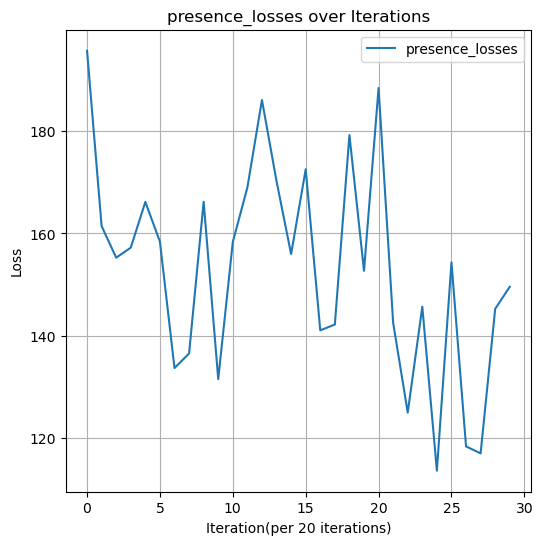

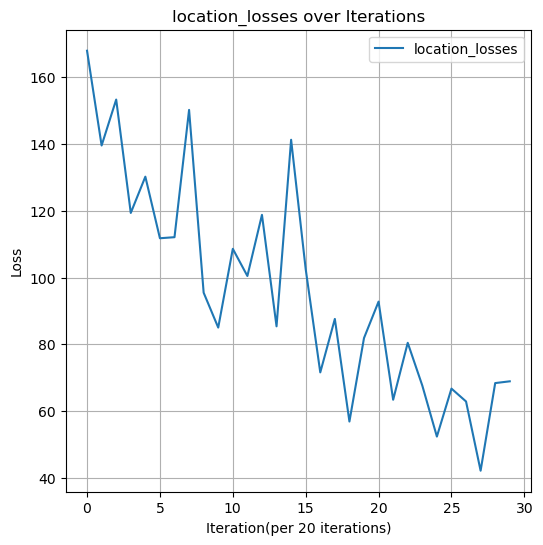

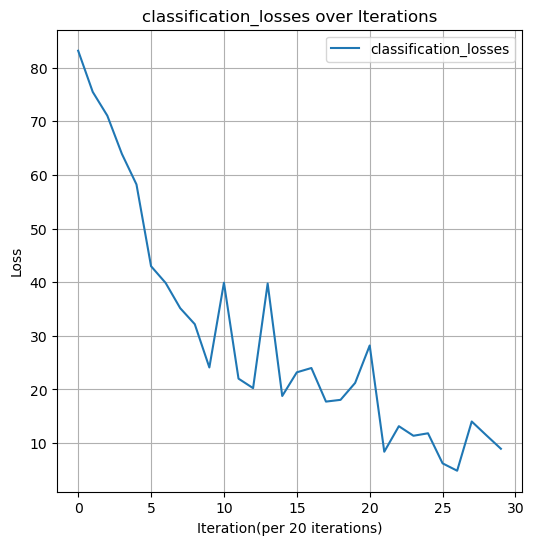

Model saved as model_yolo.pth


In [ ]:
import matplotlib.pyplot as plt

def TrainingLoop(model, dataloader):

    # switch model to training mode
    model.train()

    # move model to gpu if available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)


    # Since the first element of the YOLO vector is to indicate the presence or the absence of object 
    # in a specific anchor-box of a specific cell, I use nn.BCELoss for that purpose.
    BCELoss = nn.BCEWithLogitsLoss(reduction='sum')          # For the first element of the 8 element yolo vector                ## (1)
      
    
    # The next four elements carry purely numerical values that indicate the precise location of the object 
    # vis-a-vis the center of the cell to which the object is assigned and also the precise height 
    # and the width of the object bounding-box, I use nn.MSELoss for these four elements. 
    MSELoss = nn.MSELoss(reduction='sum')          # For the regression elements (indexed 2,3,4,5) of yolo vector      ## (2)
            
    # The last three elements are a one-hot representation of the object class label, so I use the regular 
    # nn.CrossEntropyLoss for these elements.
    CrossEntropyLoss = nn.CrossEntropyLoss(reduction='sum') # For the last three elements of the 8 element yolo vector          ## (3)
                                                        # Actually, the CrossEntropyLoss works on last four elements of
                                                        #   the augmented yolo vectors.  We add one more element to the 
                                                        #   8-element yolo vectors to allow for nilmapping.




    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.99))              
    
    TotalPresenseOrAbsenceLoss = []
    TotalLocationLoss = []
    TotalClassificationLoss = []

    # at leaset 10 epoch
    total_epoch = 10
    # total_epoch = 2

    for epoch in range(total_epoch):
        running_loss = 0.0
        print(epoch,"/",total_epoch)
        for iter, data in enumerate(dataloader):
            image, GroundTruth, len_labels = data
            # print("Input image shape:", image.shape)
            # print("GroundTruth shape", GroundTruth.shape)
            image = image.to(device)
            GroundTruth = GroundTruth.to(device)

            optimizer.zero_grad()

            pred = model(image)
            

            # print("pred.shape",pred.shape)
            pred = pred.view(-1, 5, 6*6, 9)            
            # print("pred.shape",pred.shape)


            # Extract the channel that indicates object presence with ground truth.
            object_presence = GroundTruth[:,:,:,0]  # GroundTruth: [batch_size, grid_height, grid_width, 5 + num_classes]

            # Create a mask where the value is 1, meaning an object is present.
            object_mask = object_presence == 1 ## shape: [Batch size, 36, 5]!!!


            #indicate the presence or the absence of object in a specific anchor-box of a specific cell, 
            # I use nn.BCELoss for that purpose.
            # print("Pred shape:", pred[...,0].shape)
            # print("GroundTruth shape:", GroundTruth[...,0].shape)
            PresenseOrAbsenceLoss = BCELoss(pred[...,0], GroundTruth[...,0]) # first element of yolovector, represents the objectness score

            # Center, height and width. 2nd to 5th elements from the last dimension, corresponding to the bounding box coordinates
            # pred[object_mask], it flattens and selects only the values where object_mask is True, the result is a 1D 
            # tensor of size [num_objects, 9], where num_objects is the count of True values in object_mask
            LocationLoss = MSELoss(pred[object_mask][:, 1:5], GroundTruth[object_mask][:, 1:5])  

            # one hot encoding classificication
            ClassificationLoss = CrossEntropyLoss(pred[object_mask][:,5:], torch.argmax(GroundTruth[object_mask][:, 5:], dim=1))

            total_loss = PresenseOrAbsenceLoss + LocationLoss +ClassificationLoss

            total_loss.backward()
            optimizer.step()

            running_loss += total_loss.item()

            if (iter+1) % 20 == 0:
                print(f"Iteration {iter+1}: Loss = {running_loss / 60:.4f} PresenseOrAbsenceLoss = {PresenseOrAbsenceLoss / 20:.4f}LocationLoss = {LocationLoss / 20:.4f}ClassificationLoss = {ClassificationLoss / 20:.4f}")
                running_loss = 0.0
                TotalClassificationLoss.append(ClassificationLoss)
                TotalLocationLoss.append(LocationLoss)
                TotalPresenseOrAbsenceLoss.append(PresenseOrAbsenceLoss)

    return TotalPresenseOrAbsenceLoss, TotalLocationLoss, TotalClassificationLoss




model = NetForYolo()
TotalPresenseOrAbsenceLoss, TotalLocationLoss, TotalClassificationLoss = TrainingLoop(model, train_loader)

torch.save(model.state_dict(), 'model_yolo.pth')
print("Model saved as model_yolo.pth")


presence_losses = [loss.item() for loss in TotalPresenseOrAbsenceLoss]
location_losses = [loss.item() for loss in TotalLocationLoss]
classification_losses = [loss.item() for loss in TotalClassificationLoss]

plt.figure(figsize=(6, 6))
plt.plot(presence_losses, label='presence_losses')
plt.xlabel('Iteration(per 20 iterations)')
plt.ylabel('Loss')
plt.title('presence_losses over Iterations')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(6, 6))
plt.plot(location_losses, label='location_losses')
plt.xlabel('Iteration(per 20 iterations)')
plt.ylabel('Loss')
plt.title('location_losses over Iterations')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(6, 6))
plt.plot(classification_losses, label='classification_losses')
plt.xlabel('Iteration(per 20 iterations)')
plt.ylabel('Loss')
plt.title('classification_losses over Iterations')
plt.legend()
plt.grid(True)
plt.show()




### 3.3 BCE, CE, MSE loss curves

# 4. Evaluation

### 4.1 Code block translate yolo tensor to BB pred and class label

In [ ]:
import torch
import torchvision
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from torch.utils.data import DataLoader
import os

def unnormalize_image(img):
    return (img * 0.5 + 0.5).clamp(0, 1)


# Convert YOLO output tensor to bounding boxes, confidence scores, and class labels
def yolo_to_bbox(yolo_output, num_cell=6, image_size=128, num_anchors=5):
    batch_size = yolo_output.shape[0]
    all_boxes = []
    all_scores = []
    all_labels = []
    
    cell_size = image_size / num_cell

    # Grid cell coordinates,  copy from  MyDataset 
    x, y = torch.meshgrid(torch.arange(num_cell, device=yolo_output.device), torch.arange(num_cell, device=yolo_output.device))
    grid_coords = torch.stack((x.flatten(), y.flatten()), dim=1) * cell_size
    

    # Anchor box def, copy from  MyDataset 
    anchor_boxes = []
    anchor_boxes.append([0, 0, cell_size, cell_size])  # 1:1
    anchor_boxes.append([0, -1 * cell_size, cell_size, 2 * cell_size])  # 1:3
    anchor_boxes.append([0, -2 * cell_size, cell_size, 3 * cell_size])  # 1:5
    anchor_boxes.append([-1 * cell_size, 0, 2 * cell_size, cell_size])  # 3:1
    anchor_boxes.append([-2 * cell_size, 0, 3 * cell_size, cell_size])  # 5:1

    anchor_boxes = torch.tensor(anchor_boxes, device=yolo_output.device)
    

    # set a confidence threshold to capture potential detections
    conf_threshold = 0.3
    
    for b in range(batch_size):
        boxes = []
        scores = []
        labels = []
        

        # shape of yolo_output is (batch size, 5, 6*6, 9)
        for a in range(num_anchors):
            for g in range(num_cell * num_cell):
                # Object presence confidence(the first item of yolovector)
                confidence = torch.sigmoid(yolo_output[b, a, g, 0]).item() # 
                
                # yolovector : [pc, cx, cy, w, h, p1, p2, ... pn]
                if confidence > conf_threshold:
                    # Extract predicted values
                    x_offset = yolo_output[b, a, g, 1].item() * cell_size
                    y_offset = yolo_output[b, a, g, 2].item() * cell_size
                    
                    # Get grid cell coordinates
                    cell_x, cell_y = grid_coords[g]
                    
                    # Center of predicted box
                    center_x = cell_x + x_offset
                    center_y = cell_y + y_offset
                    
                    # Get anchor box dimensions
                    anchor_box = anchor_boxes[a]
                    anchor_width = anchor_box[2] - anchor_box[0]
                    anchor_height = anchor_box[3] - anchor_box[1]
                    
                    # Width and height predictions
                    width = anchor_width * torch.exp(yolo_output[b, a, g, 3]).item()
                    height = anchor_height * torch.exp(yolo_output[b, a, g, 4]).item()
                    
                    # Convert to [x1, y1, x2, y2] format
                    x1 = center_x - width / 2
                    y1 = center_y - height / 2
                    x2 = center_x + width / 2
                    y2 = center_y + height / 2
                    
                    # Ensure box is within image boundaries
                    x1 = max(0, min(image_size, x1))
                    y1 = max(0, min(image_size, y1))
                    x2 = max(0, min(image_size, x2))
                    y2 = max(0, min(image_size, y2))
                    
                    # Get predicted class
                    class_probs = yolo_output[b, a, g, 5:8]
                    class_idx = torch.argmax(class_probs).item()
                    class_score = torch.softmax(class_probs, dim=0)[class_idx].item()
                    
                    # Store results
                    boxes.append([x1, y1, x2, y2])
                    scores.append(confidence * class_score)
                    labels.append(class_idx)
        
        # Convert to tensors
        if boxes:
            boxes_tensor = torch.tensor(boxes, device=yolo_output.device)
            scores_tensor = torch.tensor(scores, device=yolo_output.device)
            
            # Apply non-maximum suppression
            keep_indices = torchvision.ops.nms(boxes_tensor, scores_tensor, iou_threshold=0.5)
            
            all_boxes.append(boxes_tensor[keep_indices].cpu().numpy())
            all_scores.append(scores_tensor[keep_indices].cpu().numpy())
            all_labels.append([labels[i] for i in keep_indices])
        else:
            all_boxes.append(np.array([]))
            all_scores.append(np.array([]))
            all_labels.append([])
    
    return all_boxes, all_scores, all_labels

# yolo tensor to bbox
def extract_ground_truth(ground_truth, num_cell=6, image_size=128, num_anchors=5):
    boxes = []
    labels = []
    
    cell_size = image_size / num_cell
    anchor_boxes = []
    anchor_boxes.append([0, 0, cell_size, cell_size])  # 1:1
    anchor_boxes.append([0, -1 * cell_size, cell_size, 2 * cell_size])  # 1:3
    anchor_boxes.append([0, -2 * cell_size, cell_size, 3 * cell_size])  # 1:5
    anchor_boxes.append([-1 * cell_size, 0, 2 * cell_size, cell_size])  # 3:1
    anchor_boxes.append([-2 * cell_size, 0, 3 * cell_size, cell_size])  # 5:1
    anchor_boxes = torch.tensor(anchor_boxes)
    
    grid_x, grid_y = torch.meshgrid(torch.arange(num_cell), torch.arange(num_cell))
    grid_coords = torch.stack((grid_x.flatten(), grid_y.flatten()), dim=1) * cell_size
    
    for a in range(num_anchors):
        for g in range(num_cell * num_cell):
            # Check if object is present
            presence = ground_truth[a, g, 0].item()
            
            # if there is object
            if presence == 1:  
                # Extract x y
                x_offset = ground_truth[a, g, 1].item() * cell_size
                y_offset = ground_truth[a, g, 2].item() * cell_size
                
                # Get grid cell coordinates
                cell_x, cell_y = grid_coords[g]
                
                # Center of ground truth box
                center_x = cell_x + x_offset
                center_y = cell_y + y_offset
                
                # Get anchor box dimensions
                anchor_box = anchor_boxes[a]
                anchor_width = anchor_box[2] - anchor_box[0]
                anchor_height = anchor_box[3] - anchor_box[1]
                
                width = anchor_width * torch.exp(ground_truth[a, g, 3]).item()
                height = anchor_height * torch.exp(ground_truth[a, g, 4]).item()
                
                # Convert to [x1, y1, x2, y2] format
                x1 = center_x - width / 2
                y1 = center_y - height / 2
                x2 = center_x + width / 2
                y2 = center_y + height / 2
                
                # Get class label
                class_probs = ground_truth[a, g, 5:8]
                class_idx = torch.argmax(class_probs).item()
                
                boxes.append([x1, y1, x2, y2])
                labels.append(class_idx)
    
    return boxes, labels


def visualize_predictions(image, boxes, scores, labels, title=None, ground_truth=None):
    # Convert image tensor to numpy array
    img = unnormalize_image(image).permute(1, 2, 0).cpu().numpy()
    
    # Create figure and axis
    fig, ax = plt.subplots(1, figsize=(8, 8))
    ax.imshow(img)
    
    # Define colors for each class (pizza, cat, bus)
    colors = ['r', 'g', 'b']
    class_names = ['pizza', 'cat', 'bus']
    
    # Draw predicted boxes
    for i in range(len(boxes)):
        box = boxes[i]
        label = labels[i]
        score = scores[i]
        
        x1, y1, x2, y2 = box
        width = x2 - x1
        height = y2 - y1
        
        # Create rectangle patch
        rect = patches.Rectangle((x1, y1), width, height, linewidth=2, 
                                 edgecolor=colors[label], facecolor='none')
        ax.add_patch(rect)
        
        # Add label and score
        label_text = f"{class_names[label]} ({score:.2f})"
        ax.text(x1, y1, label_text, color='white', fontsize=8, 
                bbox=dict(facecolor=colors[label], alpha=0.5))
    
    # If ground truth is provided, draw it with dashed lines
    if ground_truth is not None:
        # Process ground truth to get boxes, classes
        gt_boxes, gt_labels = extract_ground_truth(ground_truth)
        
        for box, label in zip(gt_boxes, gt_labels):
            x1, y1, x2, y2 = box
            width = x2 - x1
            height = y2 - y1
            
            # Create dashed rectangle for ground truth
            rect = patches.Rectangle((x1, y1), width, height, linewidth=2, 
                                    edgecolor=colors[label], facecolor='none', 
                                    linestyle='--')
            ax.add_patch(rect)
    
    if title:
        ax.set_title(title)
    
    # Turn off axis
    ax.axis('off')
    
    return fig


def evaluate_model(model, data_loader, device):    
    # Store results for best examples and failure cases for each class
    class_names = ['pizza', 'cat', 'bus']
    best_examples = {name: [] for name in class_names} ## {'cat': [], 'dog': [], 'bird': []} (dictionary)
    failure_examples = {name: [] for name in class_names}
    
    # 0: pizza, 1: cat, 2: bus    
    gt_class_counts = {0: 0, 1: 0, 2: 0}  

    # Process the entire validation set to find examples of all classes
    all_results = []
        
    with torch.no_grad():
        for batch_idx, (images, ground_truth, num_labels) in enumerate(data_loader):
            print(f"Processing batch {batch_idx}...")
                
            images = images.to(device)
            ground_truth = ground_truth.to(device)
            
            predictions = model(images)
            predictions = predictions.view(-1, 5, 6*6, 9)  # resize to match the size of ground truth
            
            # Convert predictions to bounding boxes
            batch_boxes, batch_scores, batch_labels = yolo_to_bbox(predictions, num_cell=6, image_size=128)
            
            for i in range(len(images)):
                image = images[i]
                gt = ground_truth[i]
                gt_boxes, gt_labels = extract_ground_truth(gt)
                
                # Update ground truth class counts
                for label in gt_labels:
                    gt_class_counts[label] += 1
                
                # Get predictions
                boxes = batch_boxes[i]
                scores = batch_scores[i]
                labels = batch_labels[i]
                
                # Skip if no ground truth 
                if len(gt_labels) == 0:
                    continue
                
                result = {
                    'image': image,
                    'boxes': boxes,
                    'scores': scores,
                    'labels': labels,
                    'ground_truth': gt,
                    'gt_boxes': gt_boxes,
                    'gt_labels': gt_labels
                }
                
                # Categorize by ground truth class
                for gt_label in set(gt_labels):
                    # Check if this image contains the class we're looking for
                    if len(boxes) == 0:
                        # No detections - this is a failure case
                        if len(failure_examples[class_names[gt_label]]) < 2:
                            failure_examples[class_names[gt_label]].append(result)
                    else:
                        # Calculate IoU between predictions and this specific ground truth class
                        gt_class_boxes = [gt_boxes[j] for j in range(len(gt_boxes)) if gt_labels[j] == gt_label]
                        
                        # Check if any prediction matches this ground truth class
                        match_found = False
                        for box, score, label in zip(boxes, scores, labels):
                            for gt_box in gt_class_boxes:
                                # Calculate IoU
                                iou = calculate_iou(box, gt_box)
                                
                                # If high IoU and correct class, consider it a good detection
                                if iou > 0.5 and label == gt_label:
                                    match_found = True
                                    break
                            
                            if match_found:
                                break
                        
                        # Add to appropriate category
                        if match_found:
                            if len(best_examples[class_names[gt_label]]) < 6:
                                best_examples[class_names[gt_label]].append(result)
                        else:
                            if len(failure_examples[class_names[gt_label]]) < 2:
                                failure_examples[class_names[gt_label]].append(result)
                
                all_results.append(result)
            
            # Check if we've found enough examples of each class
            found_enough = True
            for class_name in class_names:
                if len(best_examples[class_name]) < 6 or len(failure_examples[class_name]) < 2:
                    found_enough = False
                    break
            
            if found_enough:
                break
    
    # Print ground truth class distribution
    print("\nGround Truth Class Distribution in Processed Examples:")
    for label, count in gt_class_counts.items():
        print(f"{class_names[label]}: {count}")
    
    # If we still don't have enough examples, fill in with what we have
    print("\nCollected Examples:")
    for class_name in class_names:
        print(f"{class_name}: {len(best_examples[class_name])} best examples, {len(failure_examples[class_name])} failure cases")
    
    
    # Create output directory for visualizations
    os.makedirs("yolo_detection_results", exist_ok=True)
    
    # Visualize best examples for each class
    fig_count = 0
    for class_idx, class_name in enumerate(class_names):
        for i, result in enumerate(best_examples[class_name]):
            if i >= 6:  # Limit to 6 best examples per class
                break
                
            # For visualization - highlight only the specific class we're showcasing
            # Filter ground truth to only show the current class
            class_gt = result['ground_truth'].clone()
            # Zero out all classes except the one we're interested in
            for a in range(5):
                for g in range(36):  # 6*6 grid cells
                    if class_gt[a, g, 0] > 0.5:  # If there's an object
                        gt_class = torch.argmax(class_gt[a, g, 5:8]).item()
                        if gt_class != class_idx:
                            class_gt[a, g, 0] = 0  # Zero out presence if not the class we're interested in
            
            fig = visualize_predictions(
                result['image'], 
                result['boxes'], 
                result['scores'], 
                result['labels'],
                title=f"Best Detection - {class_name} - Example {i+1}",
                ground_truth=class_gt
            )
            fig.savefig(f"yolo_detection_results/best_{class_name}_{i+1}.png", bbox_inches='tight')
            plt.close(fig)
            fig_count += 1
    
    # Visualize failure cases for each class
    for class_idx, class_name in enumerate(class_names):
        for i, result in enumerate(failure_examples[class_name]):
            if i >= 2:  # Limit to 2 failure cases per class
                break
                
            # For visualization - highlight only the specific class we're showcasing
            class_gt = result['ground_truth'].clone()
            # Zero out all classes except the one we're interested in
            for a in range(5):
                for g in range(36):  # 6*6 grid cells
                    if class_gt[a, g, 0] > 0.5:  # If there's an object
                        gt_class = torch.argmax(class_gt[a, g, 5:8]).item()
                        if gt_class != class_idx:
                            class_gt[a, g, 0] = 0  # Zero out presence if not our focus class
            
            fig = visualize_predictions(
                result['image'], 
                result['boxes'], 
                result['scores'], 
                result['labels'],
                title=f"Failure Case - {class_name} - Example {i+1}",
                ground_truth=class_gt
            )
            fig.savefig(f"yolo_detection_results/failure_{class_name}_{i+1}.png", bbox_inches='tight')
            plt.close(fig)
            fig_count += 1
    
    
    return best_examples, failure_examples

def calculate_iou(box1, box2):
    """Calculate intersection over union between two boxes"""
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])
    
    # Intersection area
    intersection = max(0, x2 - x1) * max(0, y2 - y1)
    
    # Union area
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
    union = box1_area + box2_area - intersection
    
    # IoU
    if union == 0:
        return 0
    
    return intersection / union


if __name__ == "__main__":
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    

    # Load the saved model and set as eval mode
    model = NetForYolo()  
    model_path = 'model_yolo.pth'
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()
    
    # Evaluate on validation set
    best_examples, failure_examples = evaluate_model(model, val_loader, device)
    


Using device: cuda


/tmp/ipykernel_2621648/481492162.py:485: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))
/tmp/ipykernel_2621

Processing batch 0...
Processing batch 1...
Processing batch 2...
Processing batch 3...
Processing batch 4...
Processing batch 5...
Processing batch 6...
Processing batch 7...

Ground Truth Class Distribution in Processed Examples:
pizza: 238
cat: 189
bus: 85

Collected Examples:
pizza: 6 best examples, 2 failure cases
cat: 6 best examples, 2 failure cases
bus: 6 best examples, 2 failure cases

Saved 24 visualization images to 'yolo_detection_results' directory

Evaluation complete! Check 'yolo_detection_results' directory for the visualization images.


### 4.2 Explanation translate yolo tensor to BB pred and class label
When processing a YOLO tensor, extract the objectness score first by applying a sigmoid function to the first element, keeping only predictions above our confidence threshold (0.5). For qualifying predictions, calculate the actual bounding box coordinates by combining grid cell positions with predicted offsets. The center coordinates (x,y) are determined by adding the predicted offsets to the grid cell's position, while width and height are calculated by applying the exponential function to the model's log-scale predictions and scaling by the corresponding anchor box dimensions. These components are then converted to the standard [x1,y1,x2,y2] format representing the box corners.


Class prediction involves identifying the highest probability class from the final elements of the YOLO vector. After extracting all potential detections, apply non-maximum suppression (NMS) to eliminate redundant overlapping boxes, keeping only the most confident detection for each object. This complete process transforms the complex YOLO tensor output into a clean set of bounding boxes with associated class labels and confidence scores, enabling effective visualization and evaluation of the model's performance on multi-instance object detection tasks.

### 4.3 24 images

# 5. Bonus IoU loss with DIoU

In [ ]:
class DIoULoss(nn.Module):
    """
    Class Path:   DLStudio  ->  DetectAndLocalize  ->  DIOULoss

    This is a Custom Loss Function for implementing the variants of the IoU 
    (Intersection over Union) loss as described on Slides 37 through 42 of my 
    Week 7 presentation on Object Detection and Localization.
    """
    def __init__(self, device, imagesize, loss_mode):
        super(DIoULoss, self).__init__()
        self.device = device
        self.imagesize = imagesize
        self.loss_mode = loss_mode

    def forward(self, predicted, target, loss_mode):
        debug = 0
        ##  We calculate the MSELoss between the predicted and the target BBs just for sanity check.
        ##  It is not used in the loss that is returned by this function [However, note that the 
        ##  d2_loss defined below is the same thing as what is returned by MSELoss]:
        displacement_loss = nn.MSELoss()(predicted, target)                                           
        ##  We call the MSELoss again, but this time with "reduction='none'".  The reason for that
        ##  is that we need to calculate the MSELoss on a per-instance basis in the batch for the
        ##  normalizations we are going to need later in our calculation of the IoU-based loss function.
        ##  The following call returns a tensor of shape (Bx4) where B is the batch size and 4
        ##  is for four numeric values in a BB vector.
        d2_loss_per_instance = nn.MSELoss(reduction='none')(predicted, target)                        
        ##  Averaging the above along Axis 1 gives us the instance based MSE Loss we want:
        d2_mean_loss_per_instance = torch.mean(d2_loss_per_instance, 1)                               
        ##  Averaging of the above along Axis 0 should give us a single scalar that would be
        ##  the same as the "displacement_loss" in the first line:
        d2_loss = torch.mean(d2_mean_loss_per_instance,0)                                             
        if debug:
            print("\n\nMSE Loss: ", displacement_loss)
            print("\n\nd2_loss_per_instance_in_batch: ", d2_loss_per_instance)
            print("\n\nd2_mean_loss_per_instance_in_batch: ", d2_mean_loss_per_instance)
            print("\n\nd2 loss: ", d2_loss)

        ##  Our next job is to figure out the BB for the convex hull of the predicted and target BBs. To 
        ##  thta end, we first find the upper-left corner of the convex hull by finding the infimum of the
        ##  of the min (i,j) coordinates associated with the predicted and the target BBs:
        hull_min_i  = torch.min( torch.cat( ( torch.transpose( torch.unsqueeze(predicted[:,0],0), 1,0 ),
                                                torch.transpose( torch.unsqueeze(predicted[:,2],0), 1,0 ),
                                                    torch.transpose( torch.unsqueeze(target[:,0],0), 1,0 ),
                                                    torch.transpose( torch.unsqueeze(target[:,2],0), 1,0 ) ), 1 ), 1 )[0].type(torch.uint8)
        hull_min_j  = torch.min( torch.cat( ( torch.transpose( torch.unsqueeze(predicted[:,1],0), 1,0 ),
                                                torch.transpose( torch.unsqueeze(predicted[:,3],0), 1,0 ),
                                                    torch.transpose( torch.unsqueeze(target[:,1],0), 1,0 ),
                                                    torch.transpose( torch.unsqueeze(target[:,3],0), 1,0 ) ), 1 ), 1 )[0].type(torch.uint8)

        ##  Next we need to find the lower-right corner of the convex hull.  We do so by finding the
        ##  supremum of the max (i,j) coordinates associated with the predicted and the target BBs:
        hull_max_i  = torch.max( torch.cat( ( torch.transpose( torch.unsqueeze(predicted[:,0],0), 1,0 ),
                                                torch.transpose( torch.unsqueeze(predicted[:,2],0), 1,0 ),
                                                    torch.transpose( torch.unsqueeze(target[:,0],0), 1,0 ),
                                                    torch.transpose( torch.unsqueeze(target[:,2],0), 1,0 ) ), 1 ), 1 )[0].type(torch.uint8)

        hull_max_j  = torch.max( torch.cat( ( torch.transpose( torch.unsqueeze(predicted[:,1],0), 1,0 ),
                                                torch.transpose( torch.unsqueeze(predicted[:,3],0), 1,0 ),
                                                    torch.transpose( torch.unsqueeze(target[:,1],0), 1,0 ),
                                                    torch.transpose( torch.unsqueeze(target[:,3],0), 1,0 ) ), 1 ), 1 )[0].type(torch.uint8)

        ##  We now call on the torch.cat to organize the instance-based convex_hull min and max coordinates
        ##  into what the convex-hull BB should look like for a batch.  If B is the batch size, the shape of 
        ##  convex_hull_bb should be (B, 4):
        convex_hull_bb = torch.cat( ( torch.transpose( torch.unsqueeze(hull_min_i,0), 1,0), 
                                        torch.transpose( torch.unsqueeze(hull_min_j,0), 1,0), 
                                        torch.transpose( torch.unsqueeze(hull_max_i,0), 1,0), 
                                        torch.transpose( torch.unsqueeze(hull_max_j,0), 1,0) ), 1 ).float().to(self.device)

        ##  Need the square of the diagonal of the convex hull for normalization:
        convex_hull_diagonal_squared  =  torch.square(convex_hull_bb[:,0] - convex_hull_bb[:,2])  +  torch.square(convex_hull_bb[:,1] - convex_hull_bb[:,3])

        ##  Since we will be using the BB corners for indexing, we need to convert them into ints:
        predicted = predicted.type(torch.uint8)
        target = target.type(torch.uint8)
        convex_hull_bb = convex_hull_bb.type(torch.uint8)

        ##  Our next job is to convert all three BBs --- predicted, target, and convex_hull --- into binary
        ##  for set operations of union, intersection, and the set-difference of the union from the 
        ##  convex hull.  We start by initializing the three arras for each instance in the batch:
        img_size = self.imagesize
        predicted_arr = torch.zeros(predicted.shape[0], img_size[0], img_size[1]).to(self.device)    
        target_arr = torch.zeros(predicted.shape[0], img_size[0], img_size[1]).to(self.device)       
        convex_hull_arr = torch.zeros(predicted.shape[0], img_size[0], img_size[1]).to(self.device)  
        ##  We fill the three arrays --- predicted, target, and convex_hull --- according to their respective BBs:
        for k in range(predicted_arr.shape[0]):                                                            
            predicted_arr[ k, predicted[k,0]:predicted[k,2],  predicted[k,1]:predicted[k,3] ] = 1         
            target_arr[ k, target[k,0]:target[k,2],  target[k,1]:target[k,3] ] = 1         
            convex_hull_arr[ k, convex_hull_bb[k,0]:convex_hull_bb[k,2],  convex_hull_bb[k,1]:convex_hull_bb[k,3] ] = 1         
        ##  We are ready for the set operations:
        intersection_arr = predicted_arr * target_arr                                                     
        intersecs = torch.sum( intersection_arr, dim=(1,2) )                                              
        union_arr = torch.logical_or( predicted_arr > 0, target_arr > 0 ).type(torch.uint8)               
        unions = torch.sum( union_arr, dim=(1,2) )                                                        
        ## find the set difference of the convex hull and the union for each batch instance:
        diff_arr = (convex_hull_arr !=  union_arr).type(torch.uint8)
        ## what's the total number of pixels in the the set difference:            
        diff_sum_per_instance = torch.sum( diff_arr, dim=(1,2) )
        ## also, what is the total number of pixels in the convex hull for each batch instance:
        convex_hull_sum_per_instance = torch.sum( convex_hull_arr, dim=(1,2) )
        if  (convex_hull_sum_per_instance < 10).any(): return torch.tensor([float('nan')])
        ## find the ratio we need for the DIoU formula [see Eq. (8) on Slide 40 of my Week 7 slides]:
        epsilon = 1e-6
        ratio = diff_sum_per_instance.type(torch.float) / (convex_hull_sum_per_instance.type(torch.float) + epsilon) 
        ## find the IoU            
        iou = intersecs / (unions + epsilon)                          
        iou_loss = torch.mean(1 - iou, 0)                             
        d2_normed = d2_mean_loss_per_instance / (convex_hull_diagonal_squared + epsilon)     
        d2_normed_loss = torch.mean(d2_normed, 0)        
        ratio_loss  =  torch.mean( ratio, 0 )
        if self.loss_mode == 'd2':
            diou_loss =  d2_loss                         
        elif self.loss_mode == 'diou1':
            diou_loss = iou_loss + d2_loss               
        elif self.loss_mode == 'diou2':
            diou_loss = iou_loss + d2_normed_loss        
        elif self.loss_mode == 'diou3':
            diou_loss = iou_loss + d2_normed_loss + ratio_loss
        return diou_loss

In [ ]:
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import matplotlib.pyplot as plt

class DIoULoss(nn.Module):
    """
    Class Path: DLStudio -> DetectAndLocalize -> DIoULoss

    This is a custom loss function implementing variants of the IoU loss as described 
    on Slides 37 through 42 of the Week 7 presentation on Object Detection and Localization.
    """
    def __init__(self, device, imagesize, loss_mode):
        super(DIoULoss, self).__init__()
        self.device = device
        self.imagesize = imagesize
        self.loss_mode = loss_mode

    def forward(self, predicted, target):
        debug = 0
        # Calculate the standard MSE Loss between predicted and target bounding boxes.
        displacement_loss = nn.MSELoss()(predicted, target)
        # Calculate per-instance MSE loss without reduction.
        d2_loss_per_instance = nn.MSELoss(reduction='none')(predicted, target)
        d2_mean_loss_per_instance = torch.mean(d2_loss_per_instance, dim=1)
        d2_loss = torch.mean(d2_mean_loss_per_instance, dim=0)

        if debug:
            print("\nMSE Loss:", displacement_loss)
            print("\nd2_loss_per_instance_in_batch:", d2_loss_per_instance)
            print("\nd2_mean_loss_per_instance_in_batch:", d2_mean_loss_per_instance)
            print("\nd2 loss:", d2_loss)

        # Compute the convex hull bounding box coordinates.
        # For vertical coordinates (i) from predicted and target.
        hull_min_i = torch.min(torch.cat((predicted[:, 0].unsqueeze(1),
                                            predicted[:, 2].unsqueeze(1),
                                            target[:, 0].unsqueeze(1),
                                            target[:, 2].unsqueeze(1)), dim=1), dim=1)[0].long()
        hull_min_j = torch.min(torch.cat((predicted[:, 1].unsqueeze(1),
                                            predicted[:, 3].unsqueeze(1),
                                            target[:, 1].unsqueeze(1),
                                            target[:, 3].unsqueeze(1)), dim=1), dim=1)[0].long()

        hull_max_i = torch.max(torch.cat((predicted[:, 0].unsqueeze(1),
                                            predicted[:, 2].unsqueeze(1),
                                            target[:, 0].unsqueeze(1),
                                            target[:, 2].unsqueeze(1)), dim=1), dim=1)[0].long()
        hull_max_j = torch.max(torch.cat((predicted[:, 1].unsqueeze(1),
                                            predicted[:, 3].unsqueeze(1),
                                            target[:, 1].unsqueeze(1),
                                            target[:, 3].unsqueeze(1)), dim=1), dim=1)[0].long()

        # Build the convex hull bounding box tensor.
        convex_hull_bb = torch.stack([hull_min_i, hull_min_j, hull_max_i, hull_max_j], dim=1).float().to(self.device)
        # Compute the squared diagonal of the convex hull.
        convex_hull_diagonal_squared = torch.square(convex_hull_bb[:, 0] - convex_hull_bb[:, 2]) + \
                                       torch.square(convex_hull_bb[:, 1] - convex_hull_bb[:, 3])

        # Convert bounding boxes to integer type for indexing.
        predicted = predicted.long()
        target = target.long()
        convex_hull_bb = convex_hull_bb.long()

        # Create binary masks for the bounding boxes.
        img_size = self.imagesize
        batch_size = predicted.shape[0]
        predicted_arr = torch.zeros(batch_size, img_size[0], img_size[1]).to(self.device)
        target_arr = torch.zeros(batch_size, img_size[0], img_size[1]).to(self.device)
        convex_hull_arr = torch.zeros(batch_size, img_size[0], img_size[1]).to(self.device)

        for k in range(batch_size):
            predicted_arr[k, predicted[k, 0]:predicted[k, 2], predicted[k, 1]:predicted[k, 3]] = 1
            target_arr[k, target[k, 0]:target[k, 2], target[k, 1]:target[k, 3]] = 1
            convex_hull_arr[k, convex_hull_bb[k, 0]:convex_hull_bb[k, 2], convex_hull_bb[k, 1]:convex_hull_bb[k, 3]] = 1

        # Compute intersection and union.
        intersection_arr = predicted_arr * target_arr
        intersecs = torch.sum(intersection_arr, dim=(1, 2))
        union_arr = torch.logical_or(predicted_arr > 0, target_arr > 0).long()
        unions = torch.sum(union_arr, dim=(1, 2))

        # Compute set difference between convex hull and union.
        diff_arr = (convex_hull_arr != union_arr).long()
        diff_sum_per_instance = torch.sum(diff_arr, dim=(1, 2))
        convex_hull_sum_per_instance = torch.sum(convex_hull_arr, dim=(1, 2))
        if (convex_hull_sum_per_instance < 10).any():
            return torch.tensor([float('nan')]).to(self.device)

        epsilon = 1e-6
        ratio = diff_sum_per_instance.float() / (convex_hull_sum_per_instance.float() + epsilon)
        iou = intersecs.float() / (unions.float() + epsilon)
        iou_loss = torch.mean(1 - iou)
        d2_normed = d2_mean_loss_per_instance / (convex_hull_diagonal_squared + epsilon)
        d2_normed_loss = torch.mean(d2_normed)
        ratio_loss = torch.mean(ratio)

        # Combine the loss components according to the selected mode.
        if self.loss_mode == 'd2':
            diou_loss = d2_loss
        elif self.loss_mode == 'diou1':
            diou_loss = iou_loss + d2_loss
        elif self.loss_mode == 'diou2':
            diou_loss = iou_loss + d2_normed_loss
        elif self.loss_mode == 'diou3':
            diou_loss = iou_loss + d2_normed_loss + ratio_loss
        else:
            raise ValueError("Unknown loss_mode provided.")

        return diou_loss

def TrainingLoop(model, dataloader):
    # Set the device and move the model.
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.train()

    # Define the loss functions.
    BCELoss = nn.BCEWithLogitsLoss(reduction='sum')    # For objectness score.
    CrossEntropyLoss = nn.CrossEntropyLoss(reduction='sum')  # For classification.

    # Use DIoU loss for bounding box regression.
    diou_loss_fn = DIoULoss(device, imagesize=(128, 128), loss_mode='diou1')

    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.99))
    
    TotalPresenseOrAbsenceLoss = []
    TotalLocationLoss = []
    TotalClassificationLoss = []

    total_epoch = 10

    for epoch in range(total_epoch):
        running_loss = 0.0
        print(f"Epoch {epoch+1}/{total_epoch}")
        for iter, data in enumerate(dataloader):
            image, GroundTruth, len_labels = data
            image = image.to(device)
            GroundTruth = GroundTruth.to(device)

            optimizer.zero_grad()

            pred = model(image)
            # Reshape predictions as needed.
            pred = pred.view(-1, 5, 6*6, 9)

            # Extract the channel that indicates object presence.
            object_presence = GroundTruth[:, :, :, 0]
            object_mask = object_presence == 1

            # Compute losses.
            PresenceOrAbsenceLoss = BCELoss(pred[..., 0], GroundTruth[..., 0])
            LocationLoss = diou_loss_fn(pred[object_mask][:, 1:5], GroundTruth[object_mask][:, 1:5])
            ClassificationLoss = CrossEntropyLoss(pred[object_mask][:, 5:], 
                                                  torch.argmax(GroundTruth[object_mask][:, 5:], dim=1))

            total_loss = PresenceOrAbsenceLoss + LocationLoss + ClassificationLoss
            total_loss.backward()
            optimizer.step()

            running_loss += total_loss.item()

            if (iter + 1) % 20 == 0:
                avg_loss = running_loss / 20
                print(f"Iteration {iter+1}: Total Loss = {avg_loss:.4f} | Presence Loss = {PresenceOrAbsenceLoss.item()/20:.4f} | "
                      f"Location Loss = {LocationLoss.item()/20:.4f} | Classification Loss = {ClassificationLoss.item()/20:.4f}")
                running_loss = 0.0
                TotalClassificationLoss.append(ClassificationLoss.detach().cpu())
                TotalLocationLoss.append(LocationLoss.detach().cpu())
                TotalPresenseOrAbsenceLoss.append(PresenceOrAbsenceLoss.detach().cpu())

    return TotalPresenseOrAbsenceLoss, TotalLocationLoss, TotalClassificationLoss





model = NetForYolo()
TotalPresenseOrAbsenceLoss, TotalLocationLoss, TotalClassificationLoss = TrainingLoop(model, train_loader)

torch.save(model.state_dict(), 'model_yolo.pth')
print("Model saved as model_yolo.pth")


presence_losses = [loss.item() for loss in TotalPresenseOrAbsenceLoss]
location_losses = [loss.item() for loss in TotalLocationLoss]
classification_losses = [loss.item() for loss in TotalClassificationLoss]

plt.figure(figsize=(6, 6))
plt.plot(presence_losses, label='presence_losses')
plt.xlabel('Iteration(per 20 iterations)')
plt.ylabel('Loss')
plt.title('presence_losses over Iterations')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(6, 6))
plt.plot(location_losses, label='location_losses')
plt.xlabel('Iteration(per 20 iterations)')
plt.ylabel('Loss')
plt.title('location_losses over Iterations')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(6, 6))
plt.plot(classification_losses, label='classification_losses')
plt.xlabel('Iteration(per 20 iterations)')
plt.ylabel('Loss')
plt.title('classification_losses over Iterations')
plt.legend()
plt.grid(True)
plt.show()




Epoch 1/10


/tmp/ipykernel_2621648/827607155.py:132: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  anchor_box = np.argmax(torchvision.ops.box_iou(GT_box, torch.tensor(shifted_anchor_boxes)).numpy())
/tmp/ipykernel_2621648/827607155.py:138: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  w = np.log((bbox[2] - bbox[0]) / (BestBox[2] - BestBox[0]))
/tmp/ipykernel_2621648/827607155.py:139: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  h = np.log((bbox[3] - bbox[1]) / (BestBox[3] - BestBox[1]))


### 5.1 BCE, CE, DIoU loss curves

### 5.2 24 images